In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Using Skicit-learn to split data into training and testing sets 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import rasterio
import geopandas as gpd

import pystac_client 
import planetary_computer as pc

from shapely.geometry import Polygon
from sklearn.metrics import RocCurveDisplay



#import iceplant_detection_functions as ipf

In [2]:
from imblearn.over_sampling import SMOTE

In [3]:
#pip install -U imbalanced-learn

### FUNCTIONS USED
These need to be moved to an external script

In [4]:
def iceplant_counts(df):
    return df.filter(items=['iceplant']).groupby(['iceplant']).size().reset_index(name='count')

def test_train_from_df(df,test_size=0.3):
    # Labels are the values we want to predict
    labels = np.array(df['iceplant'])
    #Convert to numpy array
    features = np.array(df.drop('iceplant', axis = 1))
    return train_test_split(features, labels, test_size = test_size, random_state = 42)

# --- check proportions of ice plant vs no ice plant in train/test sets
def test_train_proportions(train_labels, test_labels):
    print('TRAIN SET: Iceplant / no iceplant counts')
    unique, counts = np.unique(train_labels,return_counts=True)
    print(np.column_stack((unique,counts)), '\n')

    print('TEST SET: Iceplant / no iceplant counts')
    unique, counts = np.unique(test_labels,return_counts=True)
    print(np.column_stack((unique,counts)))
    print()
    return

# --- check shapes of train/test features/labels
def  train_test_shapes(train_features, train_labels, test_features, test_labels):
    print('Training Features Shape:', train_features.shape) 
    print('Training Labels Shape:', train_labels.shape) 
    print('Testing Features Shape:', test_features.shape) 
    print('Testing Labels Shape:', test_labels.shape)
    print()
    return

# **********************************************************************************************************

def print_accuracy_info(test_labels,predictions_class):
    N = test_labels.shape[0]
    results = confusion_matrix(test_labels,predictions_class, normalize = 'true')
    
    confmtx = confusion_matrix(test_labels,predictions_class)
    print('true negatives:', confmtx[0,0], 
          '    false positives:', confmtx[0,1])
    print('false negatives:', confmtx[1,0], 
          '    true positives:', confmtx[1,1])
    print()
    unique, counts = np.unique(test_labels,return_counts=True)

    print('true negative %:', np.round(confmtx[0,0]/counts[0]*100,2))
    print('true positive rate %:', np.round(confmtx[1,1]/counts[1]*100,2))
    print()
    print('accuracy %:', np.round( (confmtx[1,1] + confmtx[0,0])/test_labels.shape[0]*100,2))
    return

def plot_roc(rfc, test_features, test_labels):
    ax = plt.gca()
    rf_disp = RocCurveDisplay.from_estimator(rfc, test_features, test_labels, ax=ax)
    return

def print_abs_errors(predictions_class, test_labels):# Calculate the absolute errors
    errors_class = abs(predictions_class - test_labels)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors_class), 2))
    return

def print_rfc_evaluation(rfc, test_features, test_labels, predictions):
    print_abs_errors(predictions, test_labels)
    print()
    print_accuracy_info(test_labels,predictions)
    plot_roc(rfc, test_features, test_labels)
    print()
    return

def open_window_in_scene(itemid, reduce_box):
    # accesing Azure storage using pystac client
    URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
    catalog = pystac_client.Client.open(URL)

    itemid = itemid,
    search = catalog.search(
        collections=["naip"],
        ids = itemid
    )
    item = list(search.get_items())[0]
    # sign and open item
    href = pc.sign(item.assets["image"].href)
    ds = rasterio.open(href)


    reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
    reduce = reduce.to_crs(ds.crs)

    win = ds.window(*reduce.total_bounds)
    subset = rasterio.open(href).read([1,2,3,4], window=win)
    return subset


def predict_over_subset(itemid, reduce_box,rfc):
    subset = open_window_in_scene(itemid, reduce_box)
    # reshape image into a np.array where each row is a pixel and the columns are the bands
    pixels = subset.reshape([4,-1]).T
    predictions_class = rfc.predict(pixels)
    # turn back into original raster dimensions
    return predictions_class.reshape([subset.shape[1],-1])

# **********************************************************************************************************
# image is a (4,m,n) np array in which bands are r,g,b,nir

def select_ndvi_df(image,thresh=0.2):
    # reshape image into a np.array where each row is a pixel and the columns are the bands
    pixels = image.reshape([4,-1]).T
    df = pd.DataFrame(pixels, columns=['r','g','b','nir'])
    df['ndvi']=(df.nir.astype('int16') - df.r.astype('int16'))/(df.nir.astype('int16') + df.r.astype('int16'))
    vegetation = df[df.ndvi>thresh]
    vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
    return vegetation

# ---------------------------------
def df_backto_image(image, df):
    reconstruct = np.zeros((image.shape[1],image.shape[2]))
    for n in df.index:
        if df.prediction[n]==1:
            i = int((n)/reconstruct.shape[1])
            j = (n) % reconstruct.shape[1]
            reconstruct[i][j] = 1
    return reconstruct

# ---------------------------------
def mask_ndvi_and_predict(itemid, reduce_box, rfc):
    image = open_window_in_scene(itemid, reduce_box)
    veg = select_ndvi_df(image)
    index = veg.index
    features = np.array(veg)
    predictions_class = rfc.predict(features)
    c = {'prediction':predictions_class}
    predictions_df = pd.DataFrame(c, index = index)
    
    return df_backto_image(image,predictions_df)

# **********************************************************************************************************
def plot_window_in_scene(itemid, reduce_box):
    # accesing Azure storage using pystac client
    URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
    catalog = pystac_client.Client.open(URL)

    itemid = itemid,
    search = catalog.search(
        collections=["naip"],
        ids = itemid
    )
    item = list(search.get_items())[0]
    # sign and open item
    href = pc.sign(item.assets["image"].href)
    ds = rasterio.open(href)
    
    reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
    reduce = reduce.to_crs(ds.crs)
    win = ds.window(*reduce.total_bounds)
    
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(np.moveaxis(rasterio.open(href).read([1,2,3], window=win),0,-1))
    plt.show()
    
    return

# image is a (4,m,n) np array in which bands are r,g,b,nir

def select_ndvi_df(image,thresh=0.2):
    # reshape image into a np.array where each row is a pixel and the columns are the bands
    pixels = image.reshape([4,-1]).T
    df = pd.DataFrame(pixels, columns=['r','g','b','nir'])
    df['ndvi']=(df.nir.astype('int16') - df.r.astype('int16'))/(df.nir.astype('int16') + df.r.astype('int16'))
    vegetation = df[df.ndvi>thresh]
    vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
    return vegetation


# ---------------------------------

def select_ndvi_image(itemid, reduce_box):
    subset = open_window_in_scene(itemid, reduce_box)
    df = select_ndvi_df(subset)
    reconstruct = np.zeros((subset.shape[1],subset.shape[2]))
    for n in df.index:
        i = int((n)/reconstruct.shape[1])
        j = (n) % reconstruct.shape[1]
        reconstruct[i][j] = 1
    return reconstruct

## MODEL 2: 
- adding more non-iceplant vegetation points AND tree samples
- drop any point in training set with NDVI < 0.2
- covariates: r,g, b, nir

In [5]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_non_iceplant_vegetation.csv')
noniceplant_features_df = pd.read_csv(fp)
noniceplant_features_df.head(3)

Unnamed: 0                                       geometry              x  \
0           0  POINT (237140.55244983404 3814526.1699873866)  237140.552450   
1           1  POINT (236884.12087633682 3814547.9049896635)  236884.120876   
2           2  POINT (237192.64798213766 3814447.7745699394)  237192.647982   

              y    r    g    b  nifr  iceplant  
0  3.814526e+06  163  144  116   183         0  
1  3.814548e+06  114  103   95   140         0  
2  3.814448e+06   59   67   69   137         0

In [6]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_trees','trainset_trees.csv')
trees_df = pd.read_csv(fp)
trees_df.head(3)

Unnamed: 0                                       geometry              x  \
0           0   POINT (238154.89939934976 3811251.861536609)  238154.899399   
1           1  POINT (238155.35035970793 3811252.3537978763)  238155.350360   
2           2   POINT (238153.33195766463 3811266.800670018)  238153.331958   

              y   r   g   b  nifr  iceplant  
0  3.811252e+06  30  41  62    25         0  
1  3.811252e+06  32  41  63    26         0  
2  3.811267e+06  72  74  80   145         0

In [7]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','trainset_BIG.csv')
features_df = pd.read_csv(fp)
features_df.head(3)

Unnamed: 0                                       geometry              x  \
0           0  POINT (238502.90962098842 3810767.0101709925)  238502.909621   
1           1   POINT (238531.08502453016 3810765.502552128)  238531.085025   
2           2  POINT (238514.12151877338 3810770.2447426612)  238514.121519   

              y   r   g   b  nifr  iceplant  
0  3.810767e+06  87  80  87   140         1  
1  3.810766e+06  85  81  84   149         1  
2  3.810770e+06  96  83  89   149         1

In [8]:
# add non-iceplant vegetation points sample to BIG training set 
features_df = pd.concat([features_df,
                         noniceplant_features_df.sample(frac=0.01),
                         trees_df])
features_df.drop(['geometry','Unnamed: 0','x','y'],axis=1,inplace=True)
iceplant_counts(features_df)

iceplant  count
0         0   5508
1         1   1609

In [ ]:
# # add NDVI as feature
# features_df['ndvi']=(features_df.nifr.astype('int16') - features_df.r.astype('int16'))/(features_df.nifr.astype('int16') + features_df.r.astype('int16'))
# features_df.head(3)

In [ ]:
# features_df.drop(features_df[features_df['ndvi'] < 0.2].index)  #???
# features_df

In [9]:
# vegetation = features_df[features_df.ndvi>0.2]
# vegetation.drop('ndvi',axis=1,inplace=True)

# iceplant_counts(vegetation)

In [10]:
df_for_training = features_df

## SMOTE oversampling

In [13]:
# Labels are the values we want to predict
labels = np.array(df_for_training['iceplant'])
#Convert to numpy array
features = np.array(df_for_training.drop('iceplant', axis = 1))

oversample = SMOTE()
over_X, over_y = oversample.fit_resample(features, labels)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.1, stratify=over_y)
#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=150, 
                                   random_state=42)

#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)

RandomForestClassifier(n_estimators=150, random_state=42)

Mean Absolute Error: 0.0

true negatives: 1633     false positives: 5
false negatives: 1     true positives: 497

true negative %: 99.69
true positive rate %: 99.8

accuracy %: 99.72



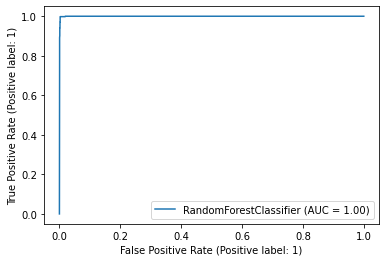

In [14]:
predictions = SMOTE_SRF.predict(test_features)

print_rfc_evaluation(SMOTE_SRF, test_features, test_labels, predictions)

/tmp/ipykernel_594/1968669404.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


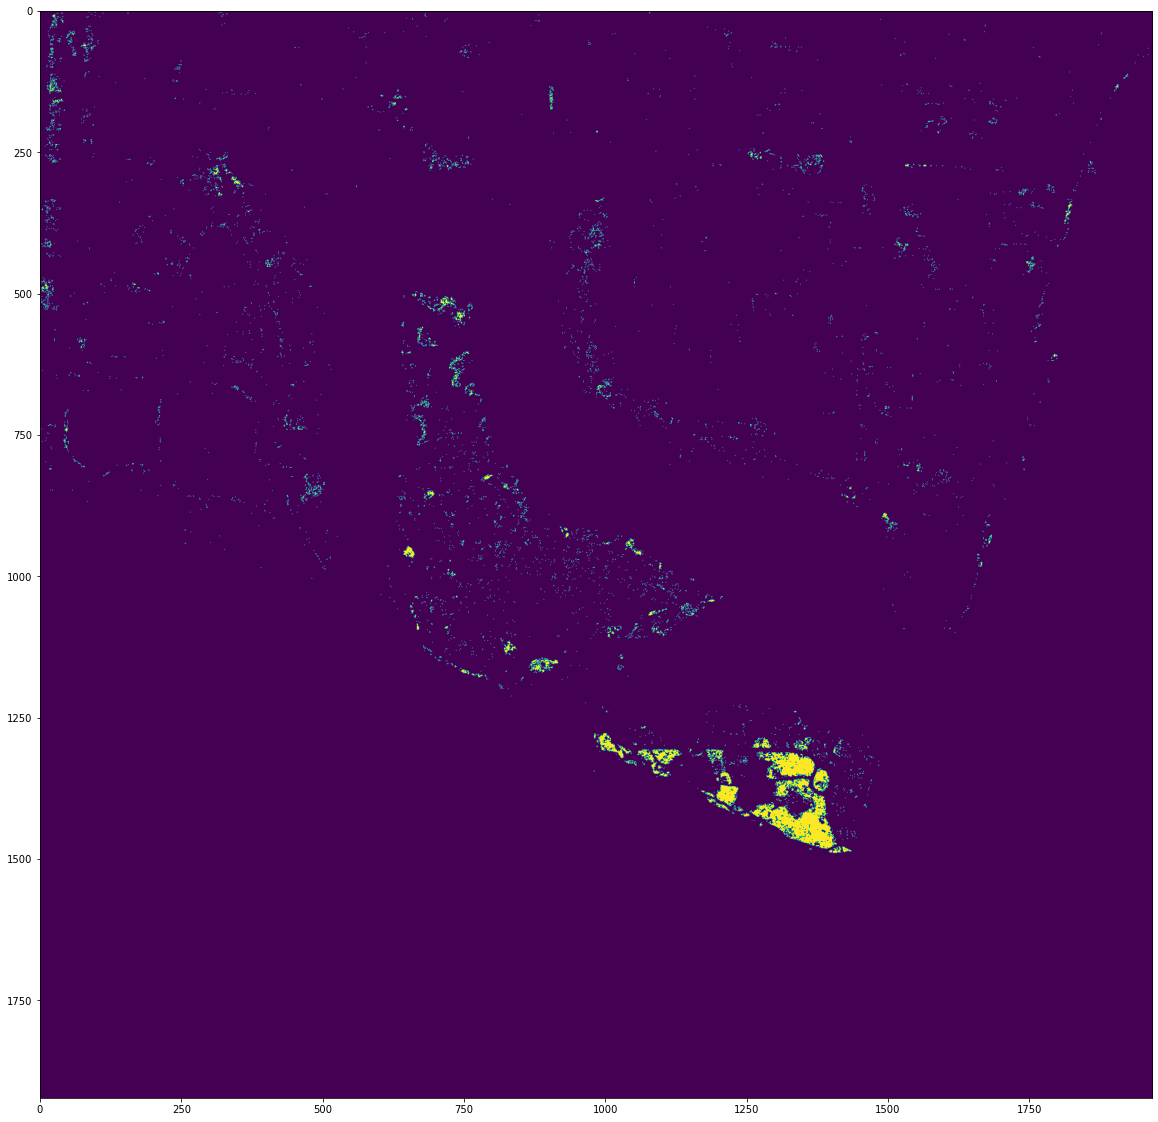

In [16]:
reconstructed = mask_ndvi_and_predict(itemid, reduce_box,SMOTE_SRF)

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(reconstructed)
plt.show()

#### Crete test and training sets

In [11]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = test_train_from_df(df_for_training)

train_test_shapes(train_features, train_labels, test_features, test_labels)
test_train_proportions(train_labels, test_labels)

Training Features Shape: (4981, 4)
Training Labels Shape: (4981,)
Testing Features Shape: (2136, 4)
Testing Labels Shape: (2136,)

TRAIN SET: Iceplant / no iceplant counts
[[   0 3870]
 [   1 1111]] 

TEST SET: Iceplant / no iceplant counts
[[   0 1638]
 [   1  498]]



#### Train random forest classifier

In [23]:
# Train random forest classifier
rfc = RandomForestClassifier(n_estimators = 100, 
                           random_state = 42)
rfc.fit(train_features,train_labels)

RandomForestClassifier(random_state=42)

Mean Absolute Error: 0.02

true negatives: 1615     false positives: 23
false negatives: 26     true positives: 472

true negative %: 98.6
true positive rate %: 94.78

accuracy %: 97.71



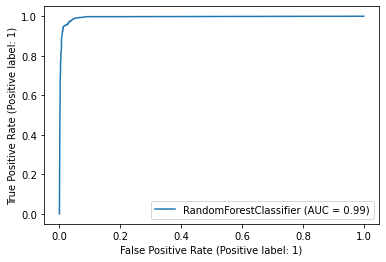

In [24]:
predictions = rfc.predict(test_features)

print_rfc_evaluation(rfc, test_features, test_labels, predictions)

### Random Forest With Class Weighting

Mean Absolute Error: 0.02

true negatives: 1617     false positives: 21
false negatives: 28     true positives: 470

true negative %: 98.72
true positive rate %: 94.38

accuracy %: 97.71



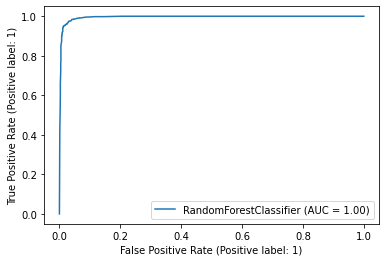

In [26]:
rfc_balanced = RandomForestClassifier(n_estimators = 100, 
                                      random_state = 42,
                                      class_weight='balanced')
rfc_balanced.fit(train_features,train_labels)
predictions_balanced = rfc_balanced.predict(test_features)
print_rfc_evaluation(rfc_balanced, test_features, test_labels, predictions_balanced)

/tmp/ipykernel_474/1968669404.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


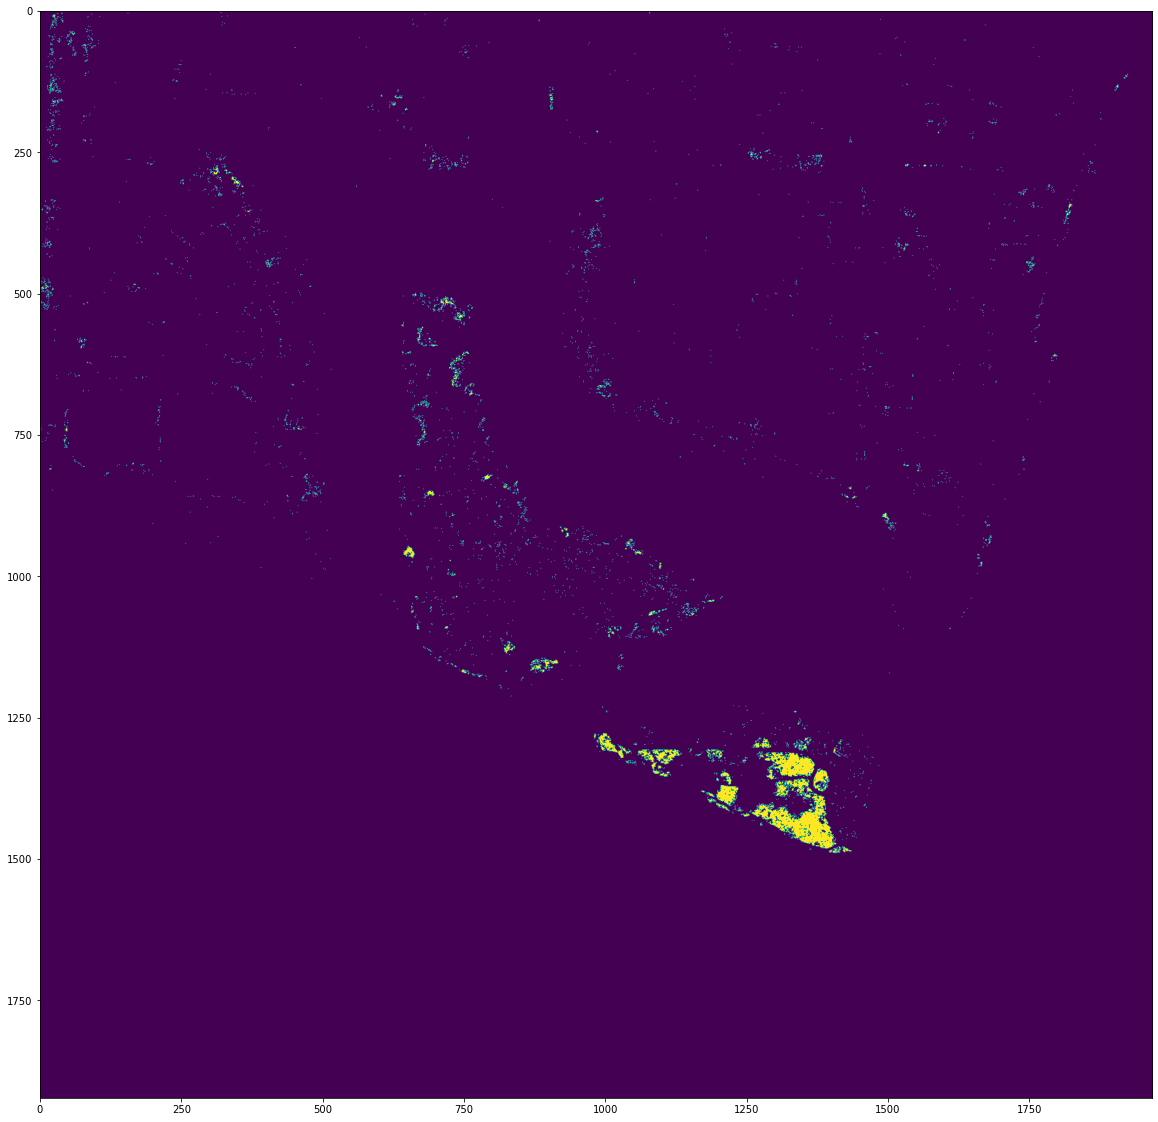

In [27]:
reconstructed = mask_ndvi_and_predict(itemid, reduce_box,rfc_balanced)

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(reconstructed)
plt.show()

## Applying MODEL 2 to NAIP subsets

In [15]:
itemid='ca_m_3411934_sw_11_060_20180722_20190209'

# use one of these polygons to make a window and load only the portion of the raster we need

#  Campus Point + Campus + Goleta Beach
# reduce_box = Polygon([
#     [-119.8533036004,34.4025961754],
#     [-119.8322357862,34.4025961754],
#     [-119.8322357862,34.4198342586],
#     [-119.8533036004,34.4198342586],
#     [-119.8533036004,34.4025961754]])


# Only Campus Point
reduce_box = Polygon([
    [-119.8534713523,34.4028697719],
    [-119.8409772016,34.4028697719],
    [-119.8409772016,34.4129840686],
    [-119.8534713523,34.4129840686],
    [-119.8534713523,34.4028697719]])

### NOT MASKING FOR NDVI

In [ ]:
#campus_point_iceplant = predict_over_subset(itemid, reduce_box, rfc)

# fig, ax = plt.subplots(figsize=(20, 20))
# ax.imshow(campus_point_iceplant)
# plt.show()

### MASKING FOR NDVI

In [15]:
reconstructed = mask_ndvi_and_predict(itemid, reduce_box,rfc)

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(reconstructed)
plt.show()

In [ ]:
# #shoreline
# shoreline_itemid= 'ca_m_3411935_sw_11_060_20180724_20190209'

# shoreline_box = Polygon(
# [[-119.7141492874,34.3930950227],
#   [-119.7023203222,34.3930950227],
#   [-119.7023203222,34.3992922273],
#   [-119.7141492874,34.3992922273],
#   [-119.7141492874,34.3930950227]])

/tmp/ipykernel_474/1968669404.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


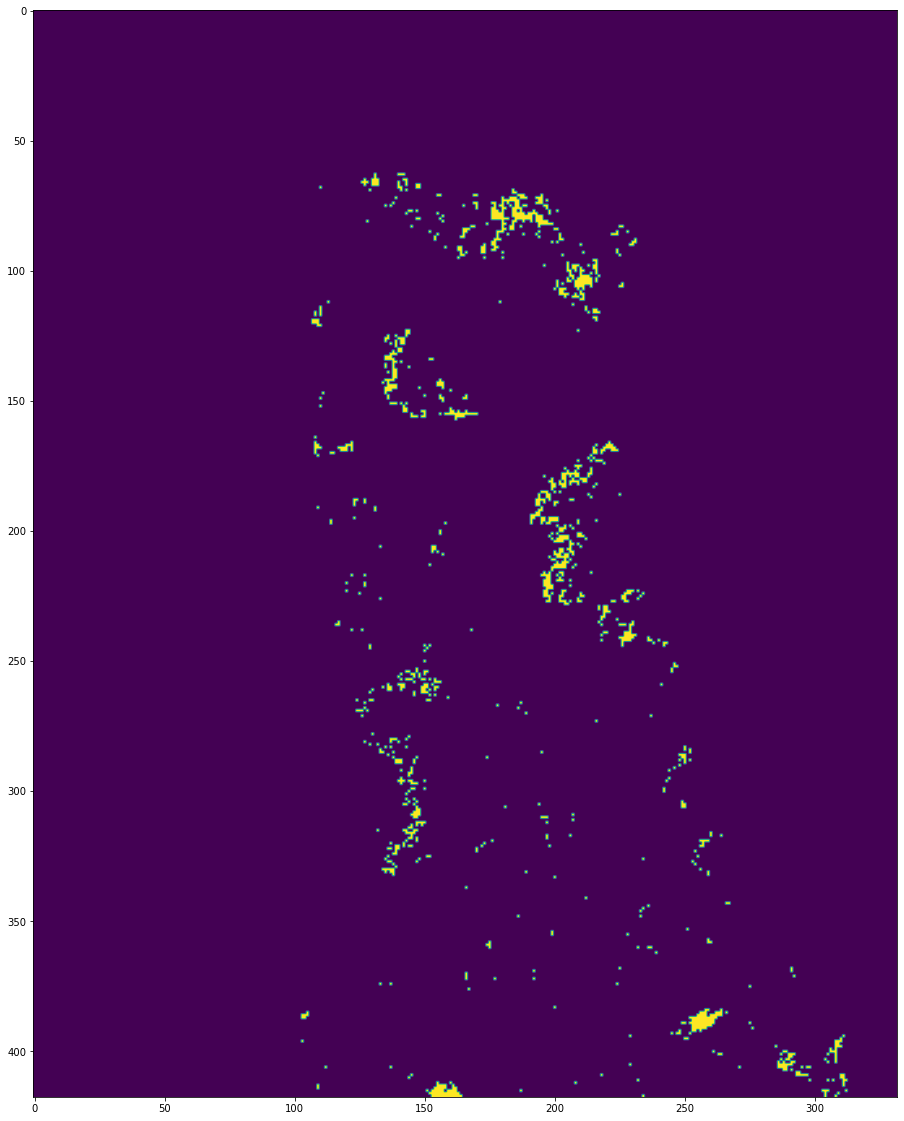

In [17]:
lagoon_zoom_box = Polygon([[-119.8501890501,34.4084820176],
                      [-119.8480929505,34.4084820176],
                      [-119.8480929505,34.4106942936],
                      [-119.8501890501,34.4106942936],
                      [-119.8501890501,34.4084820176]])

lagoon_zoom = mask_ndvi_and_predict(itemid, lagoon_zoom_box,rfc)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(lagoon_zoom)
plt.show()

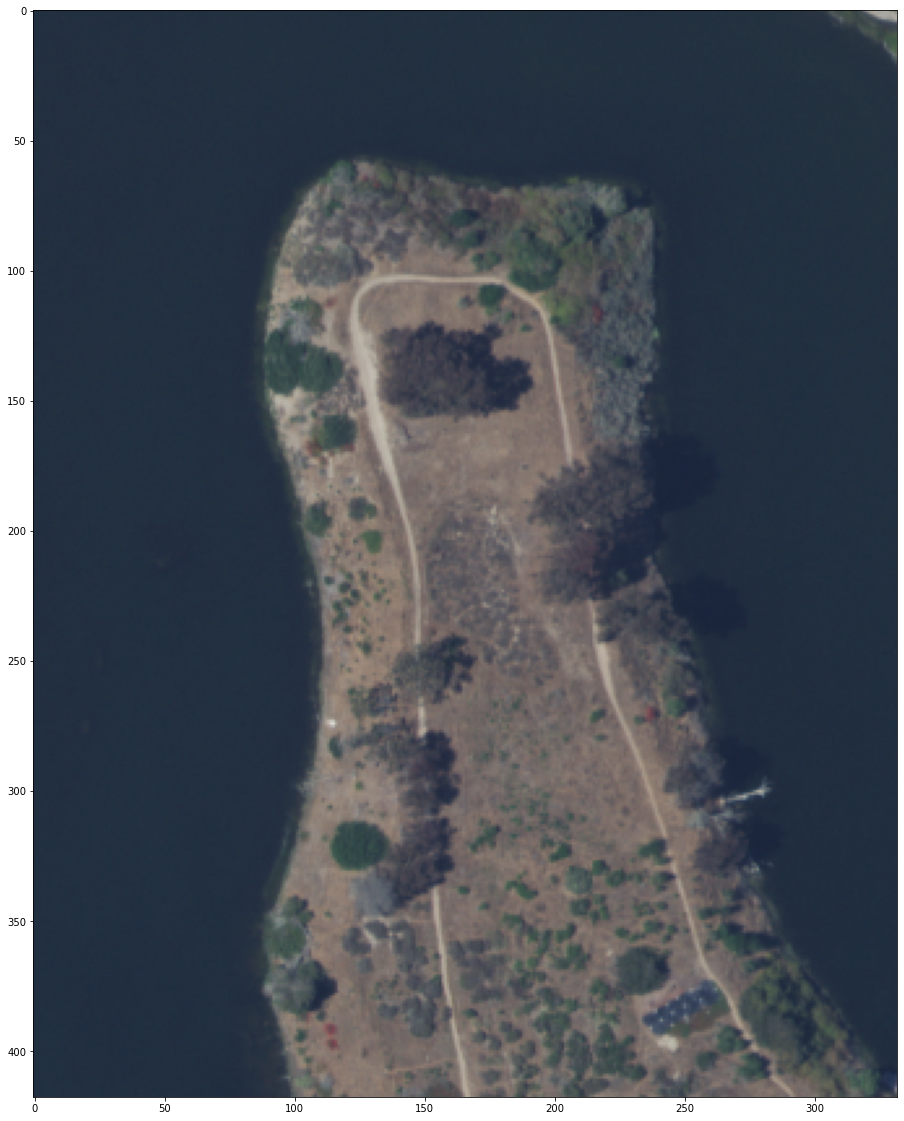

In [16]:
plot_window_in_scene(itemid, lagoon_zoom_box)

In [11]:
tree_box = Polygon([[-119.8494252218,34.4098185304],
                    [-119.8490819918,34.4098185304],
                    [-119.8490819918,34.4100837989],
                    [-119.8494252218,34.4100837989],
                    [-119.8494252218,34.4098185304]])

/tmp/ipykernel_2225/3221137585.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


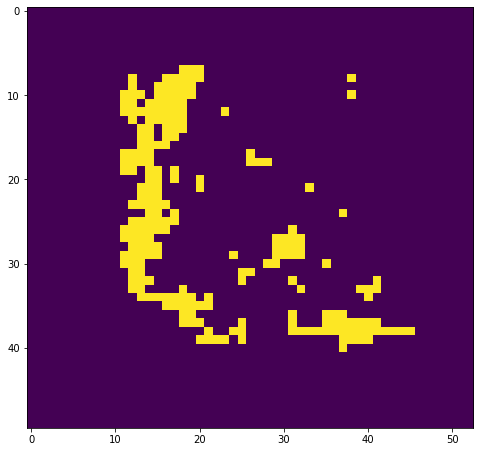

In [36]:
tree_predict = mask_ndvi_and_predict(itemid, tree_box, rfc)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(tree_predict)
plt.show()

In [31]:
tree_ndvi = select_ndvi_image(itemid,tree_box)
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(tree_ndvi)
# plt.show()

/tmp/ipykernel_2225/3221137585.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


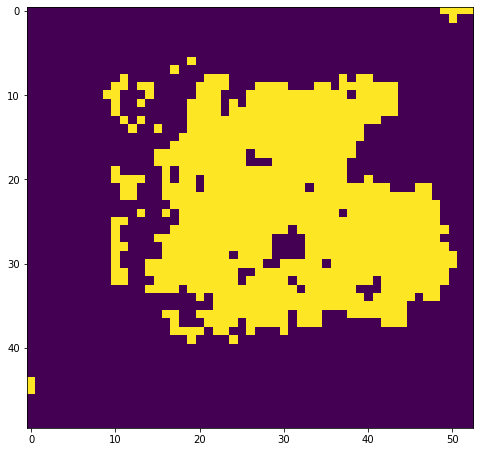

In [37]:
true_tree = tree_ndvi - tree_predict
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(true_tree)
plt.show()

In [23]:
tree_naip = open_window_in_scene(itemid, tree_box)

In [39]:
p = (tree_naip*tree_predict).reshape([4,-1]).T
p = pd.DataFrame(p, columns =['r','g','b','nir'])
df = p[(p.r!=0) & (p.g!=0) & (p.b!=0) & (p.nir!=0)]
df['classified']=1
df

/tmp/ipykernel_2225/241382099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['classified']=1


r     g     b    nir  classified
389   86.0  83.0  92.0  152.0           1
390   81.0  75.0  87.0  145.0           1
391   85.0  78.0  86.0  140.0           1
436   85.0  85.0  93.0  142.0           1
440   83.0  76.0  88.0  125.0           1
...    ...   ...   ...    ...         ...
2104  88.0  88.0  91.0  150.0           1
2105  84.0  83.0  89.0  146.0           1
2106  93.0  90.0  92.0  148.0           1
2107  97.0  89.0  91.0  147.0           1
2157  84.0  81.0  88.0  144.0           1

[221 rows x 5 columns]

In [40]:
icep_predict = tree_naip*true_tree
p = icep_predict.reshape([4,-1]).T
p = pd.DataFrame(p, columns =['r','g','b','nir'])
df2 = p[(p.r!=0) & (p.g!=0) & (p.b!=0) & (p.nir!=0)]
df2['classified']=0
df2

/tmp/ipykernel_2225/1296004054.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['classified']=0


r      g     b    nir  classified
49    89.0  105.0  88.0  161.0           0
50    82.0   98.0  83.0  157.0           0
51    85.0   98.0  85.0  150.0           0
52    88.0   95.0  90.0  135.0           0
103   87.0   96.0  83.0  148.0           0
...    ...    ...   ...    ...         ...
2044  77.0   79.0  87.0  127.0           0
2086  95.0   95.0  92.0  162.0           0
2091  82.0   86.0  90.0  142.0           0
2332  98.0   99.0  96.0  149.0           0
2385  97.0   99.0  96.0  149.0           0

[812 rows x 5 columns]

In [43]:
df = pd.concat([df,df2])
df

r     g     b    nir  classified
389   86.0  83.0  92.0  152.0           1
390   81.0  75.0  87.0  145.0           1
391   85.0  78.0  86.0  140.0           1
436   85.0  85.0  93.0  142.0           1
440   83.0  76.0  88.0  125.0           1
...    ...   ...   ...    ...         ...
2044  77.0  79.0  87.0  127.0           0
2086  95.0  95.0  92.0  162.0           0
2091  82.0  86.0  90.0  142.0           0
2332  98.0  99.0  96.0  149.0           0
2385  97.0  99.0  96.0  149.0           0

[1033 rows x 5 columns]

/tmp/ipykernel_474/1968669404.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


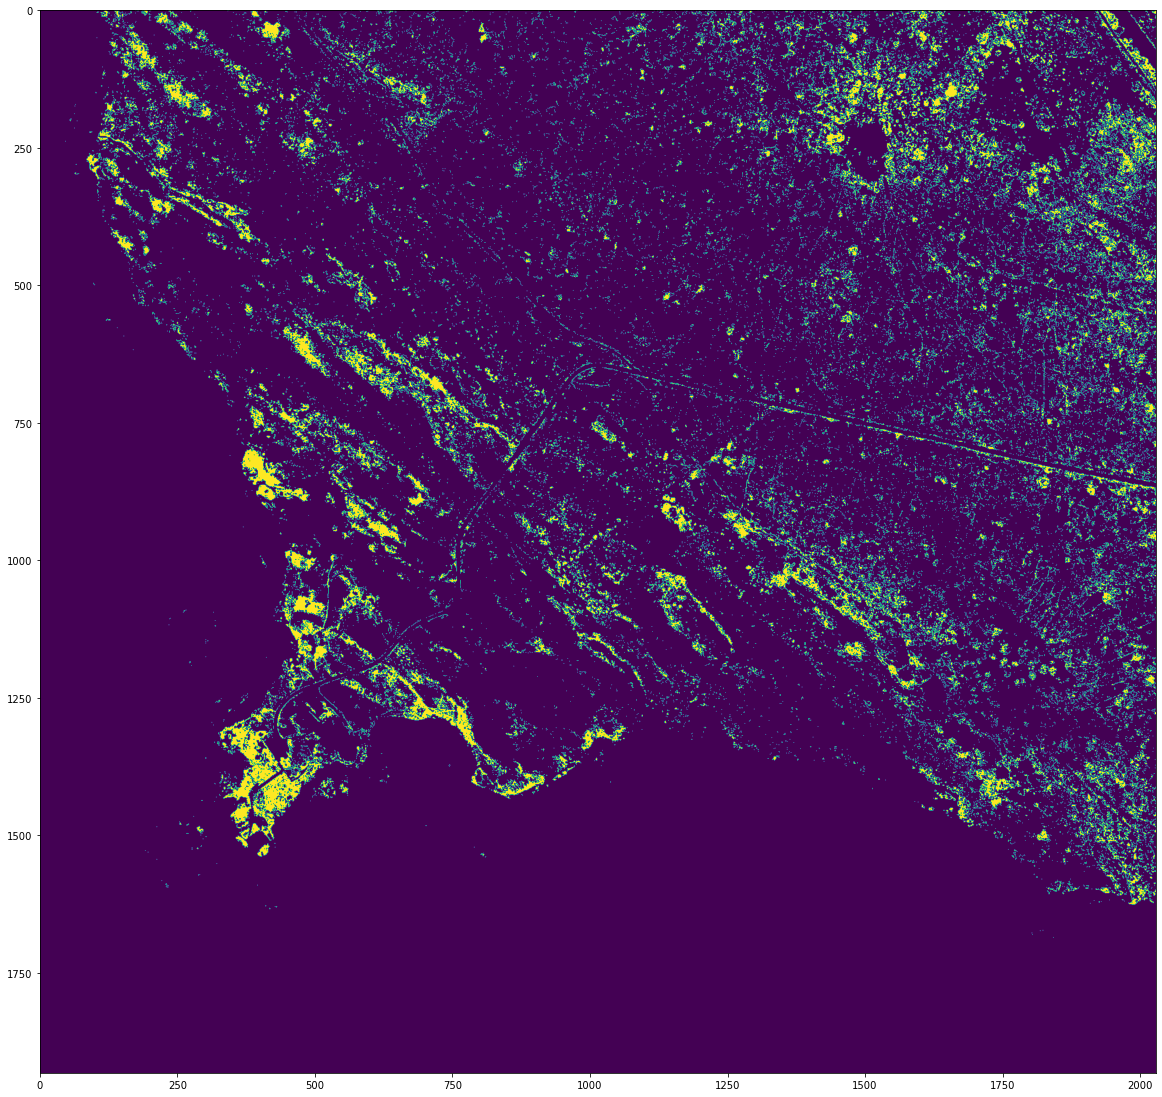

In [28]:
# ********* DANGERMOND RESERVE 2018 NAIP SCENE ******
dangermond_itemid = 'ca_m_3412037_nw_10_060_20180913_20190208'

dangermond_box = Polygon([
    [-120.4731712312,34.4464554252],
    [-120.4602250497,34.4464554252],
    [-120.4602250497,34.4566394481],
    [-120.4731712312,34.4566394481],
    [-120.4731712312,34.4464554252]])

dangermond = mask_ndvi_and_predict(dangermond_itemid, dangermond_box,rfc_balanced)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(dangermond)
plt.show()

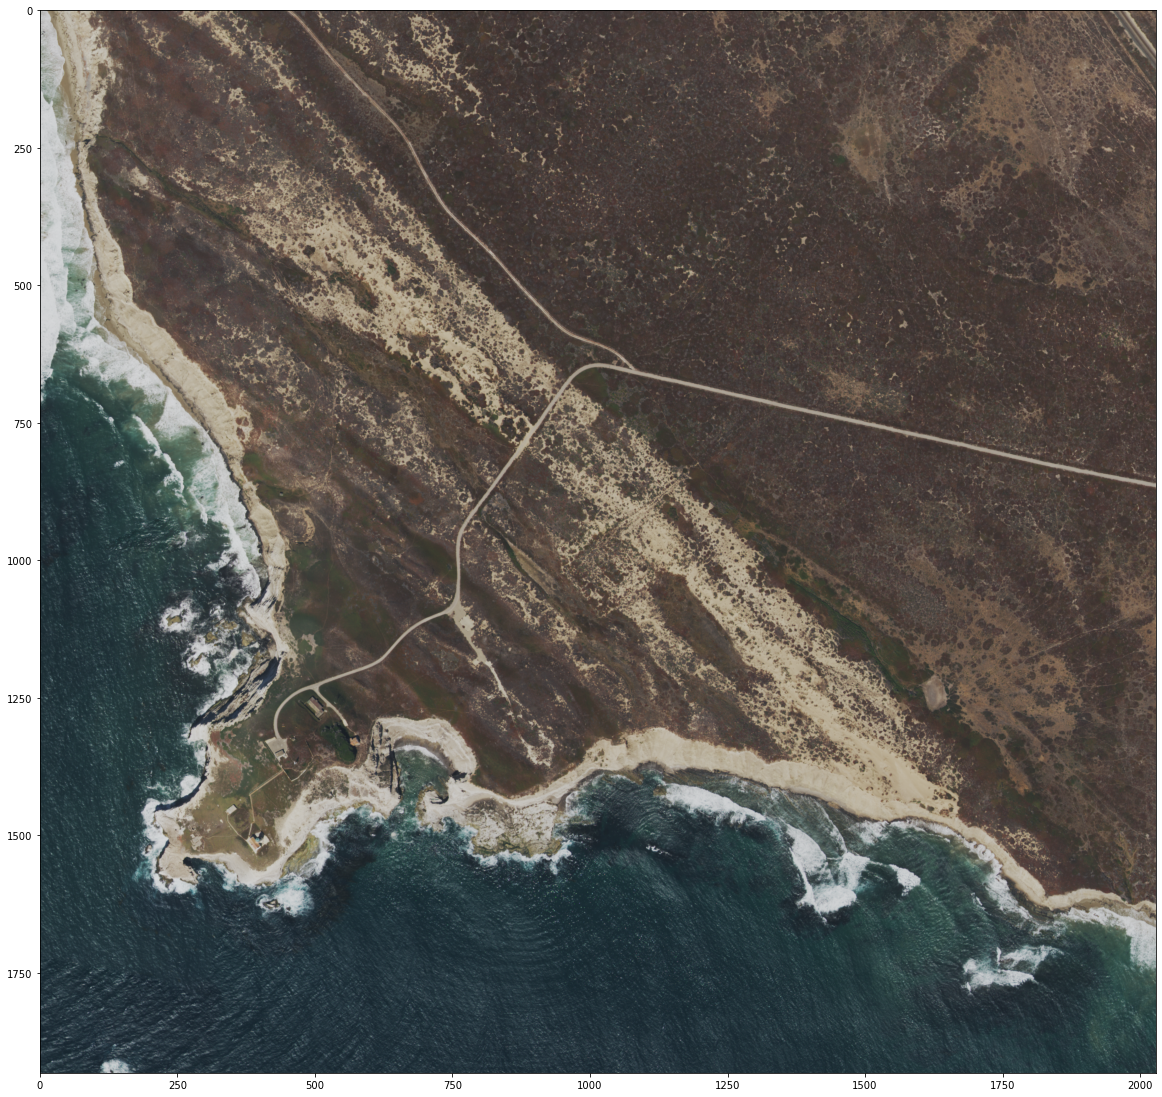

In [19]:
plot_window_in_scene(dangermond_itemid, dangermond_box)

In [ ]:
# dangermond_iceplant = predict_over_subset(itemid, reduce_box,rfc)

In [ ]:
# fig, ax = plt.subplots(figsize=(20, 20))
# ax.imshow(dangermond_iceplant)
# plt.show()

In [ ]:
# reduce_box2 = Polygon([
#     [-120.4694755983,34.4526766824],
#     [-120.4593511485,34.4526766824],
#     [-120.4593511485,34.4611333067],
#     [-120.4694755983,34.4611333067],
#     [-120.4694755983,34.4526766824]])

# dangermond_iceplant2 = predict_over_subset(itemid, reduce_box2,rfc)

In [ ]:
# fig, ax = plt.subplots(figsize=(20, 20))
# ax.imshow(dangermond_iceplant2)
# plt.show()